# Imports

In [1]:
import pandas as pd
import cv2
import os
import glob
import xlrd
import numpy as np
from pathlib import Path
from datetime import datetime
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import logging
import random
import matplotlib
from imutils import paths
from keras.utils import to_categorical
import sys
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder

pd.options.display.max_rows = 4000
pd.options.display.max_seq_items = 2000

Using Theano backend.


# Initialization

In [2]:
# initialize root folder

healthy_images_root_dir = 'healthy_images_filtered'
defect_images_root_dir = 'defect_images_filtered'

In [3]:
# get all images form folders

healthy_images_paths = list(paths.list_images(healthy_images_root_dir))
defect_images_paths = list(paths.list_images(defect_images_root_dir))

In [4]:
# read healthy images to arrays

healthy_images = []

for path in healthy_images_paths:
    image = cv2.imread(path)
    healthy_images.append([path,image])

In [5]:
len(healthy_images)

316

In [6]:
# read defect images to arrays

defect_images = []

for path in defect_images_paths:
    image = cv2.imread(path)
    defect_images.append([path,image])

In [7]:
len(defect_images)

427

# Data augmentation

For extending dataset of images, it is possible to horizontally flip or scale image with some probability to create new image. With this transformation applied twice on original dataset augmented dataset will be twice as size.

In [8]:
# save augmented images to filesystem

images = []

def write_aug_images(orig_images, images_aug, num):
    for i in range(len(images_aug)):
        path = orig_images[i][0]
        splited = path.split('/', 1)
        splited[0] = splited[0] + "_aug/"
        new_path = splited[0] + splited[1]
        aug_name = new_path + f'_fliped_aug_{num}.jpg'
        dir_path = aug_name.rsplit('/', 1)[0]
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        images.append([aug_name, images_aug[i]])
        cv2.imwrite(aug_name, images_aug[i])

In [9]:
# get only image data
h_images = [x[1] for x in healthy_images]

sometimes = lambda aug: iaa.Sometimes(0.2, aug)

# transformation
healthy_seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    
    sometimes(iaa.Affine(
            scale={"x": (1.0, 1.1), "y": (1.0, 1.1)}
        )
    )
])

# first augmentation
h_images_aug = healthy_seq(images=h_images)
write_aug_images(healthy_images, h_images_aug, 0)

# second augmentation
h_images_aug = healthy_seq(images=h_images)
write_aug_images(healthy_images, h_images_aug, 1)

In [10]:
# get only image data
d_images = [x[1] for x in defect_images]

sometimes = lambda aug: iaa.Sometimes(1./3, aug)

# transformation
defect_seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    
    sometimes(iaa.Affine(
            scale={"x": (1.0, 1.15), "y": (1.0, 1.15)}
        )
    )
])

# first augmentation
d_images_aug = defect_seq(images=d_images)
write_aug_images(defect_images, d_images_aug, 0)

# second augmentation
d_images_aug = defect_seq(images=d_images)
write_aug_images(defect_images, d_images_aug, 1)

In [11]:
del defect_images
del healthy_images
del d_images_aug
del h_images_aug

# Generation of images with VAE

Attemp to geenrate new images with VAE. Does not work very well due to unknown reasons.

In [12]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

In [13]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [14]:
random.shuffle(images)

images = images[:80]

In [15]:
# set labels according to their directory

y = []

for path in images:
    y.append(path[0].split(os.path.sep)[-2])
    
# create LabelEncoder and fit him with label values

label_encoder = LabelEncoder()
labels_num = label_encoder.fit_transform(y)

In [16]:
X = np.zeros((len(images), 288, 352, 3))

i = 0
for path in images:
    X[i] = path[1]
    i = i + 1

In [17]:
train_ratio = int(len(images) * 0.8)

x_train = X[:train_ratio]
x_test = X[train_ratio:]
y_train = labels_num[:train_ratio]
y_test = labels_num[train_ratio:]

In [18]:
original_dim = X.shape[1] * X.shape[2] * X.shape[3]
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [19]:
print(x_train.shape)

(64, 304128)


In [20]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 8
latent_dim = 2
epochs = 20

In [21]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 304128)       0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          155714048   encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [22]:
models = (encoder, decoder)
data = (x_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
#plot_model(vae, to_file='vae_mlp.png', show_shapes=True)

# train the autoencoder
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 304128)            0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 155716100 
_________________________________________________________________
decoder (Model)              (None, 304128)            156019200 
Total params: 311,735,300
Trainable params: 311,735,300
Non-trainable params: 0
_________________________________________________________________
Train on 64 samples, validate on 16 samples
Epoch 1/20
64/64 [==============================] - 33s 522ms/step - loss: 1577201.8336 - val_loss: 1148647.0938
Epoch 2/20
64/64 [==============================] - 33s 518ms/step - loss: 652750.4744 - val_loss: 223822.5174
Epoch 3/20
64/64 [==============================] - 33s 513ms/step - loss: 3483129729090220658867597261930496.0000 - val_los

In [23]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    figure = np.zeros((n, 352, 288, 3))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(352, 288, 3)
            figure[i] = digit

    matplotlib.pyplot.imshow(figure[0])
    matplotlib.pyplot.imshow(figure[1])
    matplotlib.pyplot.imshow(figure[3])
    
#     plt.figure(figsize=(10, 10))
#     digit_size = 28
#     start_range = digit_size // 2
#     end_range = (n - 1) * digit_size + start_range + 1
#     pixel_range = np.arange(start_range, end_range, digit_size)
#     sample_range_x = np.round(grid_x, 1)
#     sample_range_y = np.round(grid_y, 1)
#     plt.xticks(pixel_range, sample_range_x)
#     plt.yticks(pixel_range, sample_range_y)
#     plt.xlabel("z[0]")
#     plt.ylabel("z[1]")
#     plt.imshow(figure, cmap='Greys_r')
#     plt.savefig(filename)
#     plt.show()

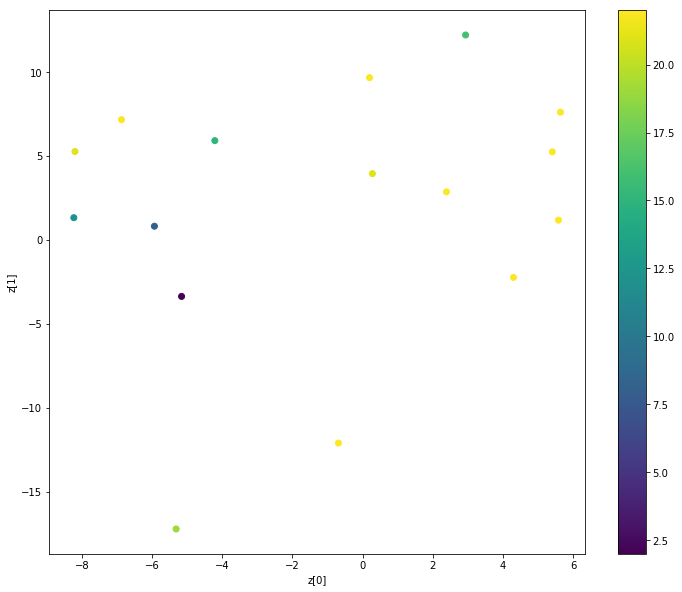

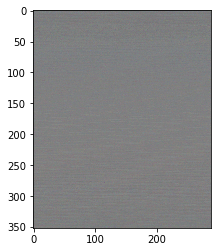

In [24]:
plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp")